# Text Classifiers:
#### This notebook contains various classifiers that can be used on a provided text dataset.

In [962]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report

import nltk
import tensorflow as tf
import keras
import sklearn
import csv

In [963]:
import itertools
import matplotlib.pyplot as plt
from sklearn import svm, datasets

## This function is called by the classifiers to provide a visulization of the results
def plot_confusion_matrix(cm, classes, Y_test,
                          predictions,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    print("Confusion Matrix:")
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j],'d'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    print(classification_report(Y_test, predictions, target_names = classes))
    print("True Negative:", cm[0][0])
    print("False Negative:", cm[1][0])
    print("True Positive:", cm[1][1])
    print("False Positive:", cm[0][1])

### Complete -> Enter the name of the dataset you want to test into the file_in variable:
##### The file_out dataset is the name of the dataset that will stored the number converted version of the text data. Set the name of file_out to the name of the converted dataset if you already have a dataset that has numeric representations of the dataset already instead of words. Otherwise, file_out will be the output file name that is the converted data of the file_in dataset that gets read in for classification for the tensorflow model. Also, if you already have a converted file, make sure that re_read is set to 0 so that it does not get overwritten.

In [964]:
### Enter filenames below:
file_in = "suggestions_trialA.csv"
file_out = "trial_taskA_converted.csv"
### Enter column names for data and labels below:
data_col = "comments"
label_col = "is_prompt_exists"
### Set re_read to 0 if you already have a converted text file, 1 if it needs to be created
re_read = 0

In [965]:
df = pd.read_csv(file_in, engine = 'python');
print(file_in)
print(df.dtypes)
print("Sample size:", len(df))
print(df.head(5))

suggestions_trialA.csv
id                  object
comments            object
is_prompt_exists     int64
dtype: object
Sample size: 2500
      id                                           comments  is_prompt_exists
0  663_3  Please enable removing language code from the ...                 1
1  663_4  Note: in your .csproj file, there is a Support...                 0
2  664_1  Wich means the new version not fully replaced ...                 0
3  664_2  Some of my users will still receive the old xa...                 0
4  664_3  The store randomly gives the old xap or the ne...                 0


#### Setting up the data.

In [966]:
X = df[data_col]
Y = df[label_col]

In [967]:
X_train, X_test, Y_train, Y_test = train_test_split(
 X, Y, test_size=0.3, random_state=42)
print("Train data amount:", len(X_train))
print("Test data amount:", len(X_test))

Train data amount: 1750
Test data amount: 750


## Multinomial Naive Bayes classifier:

In [968]:
#### Multinomial Naive Bayes
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
 ('tfidf', TfidfTransformer()),
 ('clf', MultinomialNB()),
])

In [969]:
text_clf = text_clf.fit(X_train,Y_train)

In [970]:
predicted = text_clf.predict(X_test)
accuracy = np.mean(predicted == Y_test)
print("Accuracy:", accuracy)
cm = confusion_matrix(Y_test, predicted)
print(cm)

Accuracy: 0.7413333333333333
[[556   0]
 [194   0]]


Confusion Matrix:
[[556   0]
 [194   0]]
             precision    recall  f1-score   support

      False       0.74      1.00      0.85       556
       True       0.00      0.00      0.00       194

avg / total       0.55      0.74      0.63       750

True Negative: 556
False Negative: 194
True Positive: 0
False Positive: 0


/Users/gabrielfinnrzingle/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


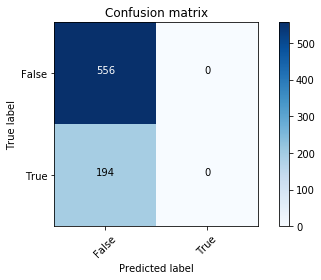

In [971]:
## Graphical visualization
cnf_matrix = confusion_matrix(Y_test, predicted)
plt.figure()
class_names = ['False, True']
plot_confusion_matrix(cnf_matrix, classes=['False', 'True'],
                      Y_test = Y_test, predictions = predicted,
                      title='Confusion matrix')

## Support Vector Machine classifier:

In [972]:
#### Support Vector Machine
text_clf_svm = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge',
                                                  penalty='l2',
                                                  max_iter=5,
                                                  random_state=42)), 
                    ])

In [973]:
_ = text_clf_svm.fit(X_train,Y_train)

In [974]:
predicted_svm = text_clf_svm.predict(X_test)
accuracy = np.mean(predicted_svm == Y_test)
print("Accuracy:", accuracy)

Accuracy: 0.816


Confusion Matrix:
[[504  52]
 [ 86 108]]
             precision    recall  f1-score   support

      False       0.85      0.91      0.88       556
       True       0.68      0.56      0.61       194

avg / total       0.81      0.82      0.81       750

True Negative: 504
False Negative: 86
True Positive: 108
False Positive: 52


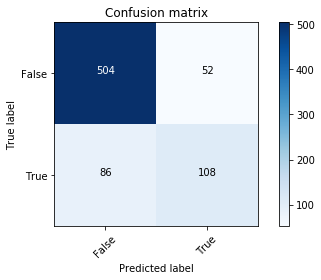

In [975]:
## Graphical visualization
cnf_matrix = confusion_matrix(Y_test, predicted_svm)
plt.figure()
class_names = ['False, True']
plot_confusion_matrix(cnf_matrix, classes=['False', 'True'],
                      Y_test = Y_test, predictions = predicted_svm,
                      title='Confusion matrix')

## Gridsearch classifier:

In [976]:
#### Gridsearch
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf-svm__alpha': (1e-2, 1e-3),
    }

In [977]:
## Can use on previous svm or bayes classifier
gs_clf = GridSearchCV(text_clf_svm, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(X_train,Y_train)
predicted_gs = gs_clf.predict(X_test)
accuracy = np.mean(predicted_gs == Y_test)

In [978]:
print("Grid search best score:", gs_clf.best_score_)
print(gs_clf.best_params_)
print("Accuracy:", accuracy)

Grid search best score: 0.8348571428571429
{'clf-svm__alpha': 0.001, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}
Accuracy: 0.82


Confusion Matrix:
[[536  20]
 [115  79]]
             precision    recall  f1-score   support

      False       0.82      0.96      0.89       556
       True       0.80      0.41      0.54       194

avg / total       0.82      0.82      0.80       750

True Negative: 536
False Negative: 115
True Positive: 79
False Positive: 20


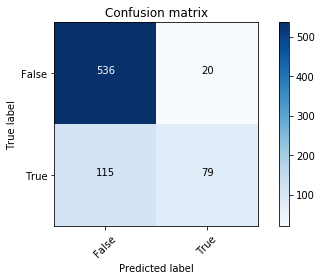

In [979]:
## Graphical visualization
cnf_matrix = confusion_matrix(Y_test, predicted_gs)
plt.figure()
class_names = ['False, True']
plot_confusion_matrix(cnf_matrix, classes=['False', 'True'],
                      Y_test = Y_test, predictions = predicted_gs,
                      title='Confusion matrix')

## Tensorflow/Keras Classifier

#### Create a numeric version of this text data set if not present (uncomment below if to do so). Also determines length of vocabulary to use for embedding layer size:

In [980]:
# Create the word mappings
def bagofwords():
    a = []
    loop = 0
    for loop in range(num_data):
        comment = df[data_col][loop]
        sentTok = nltk.sent_tokenize(comment)
        for sentence in sentTok:
            a.append(sentence)    
    a = (' '.join(a)).lower()
    text = nltk.word_tokenize(a)
    newset = set()
    for word in text:
        newset.add(word)
    # Fill in found words
    word_to_ix = { w:(i+4) for i,w in enumerate(sorted(newset)) }
    ix_to_word = { (i+4):w for i,w in enumerate(sorted(newset)) }
    # Fill in reserved values
    ix_to_word[0] = "<PAD>"
    ix_to_word[1] = "<START>"
    ix_to_word[2] = "<UNK>"
    ix_to_word[3] = "<UNUSED>"
    word_to_ix["<PAD>"] = 0 # Used to equalize text length
    word_to_ix["<START>"] = 1
    word_to_ix["<UNK>"] = 2  # unknown value
    word_to_ix["<UNUSED>"] = 3
    return word_to_ix, ix_to_word

In [981]:
word_to_ix, ix_to_word = bagofwords()
# print(ix_to_word[3853])
# print(word_to_ix["please"]) # Ensure word is in dictionary
print("Size of vocabulary:", len(ix_to_word))

Size of vocabulary: 5752


##### An update text will be printed in order to keep track of the conversion process.

In [982]:
## Convert original data to number representations
if (re_read == 1):
    num_data = len(df)
    loop = 0
    converted_text_data = []
    print("Total to print:", num_data)
    for loop in range(num_data):
        if (loop % 5000 == 0): # For larger datasets
            print("Update:", loop) # Check spot in converter
        comment = df[data_col][loop]
        if isinstance(comment, str) == False: # Skip missing text from dataset if present
            continue
        comment = comment.lower()
        text = nltk.word_tokenize(comment)
        length = len(text)
        i = 0
        for i in range(length):
            try:
                text[i] = word_to_ix[text[i]]
            except KeyError:
                text[i] = 2 # Unknown mapping
        text = [int(i) for i in text]
        converted_text_data.append(text)

In [983]:
if (re_read == 1):
    with open(file_out, 'w', newline = '') as f:
        writer = csv.writer(f)
        writer.writerow([data_col, label_col])
        i = 0
        for i in range(num_data):
            rev = converted_text_data[i]
            label = df[label_col][i]
            writer.writerow([rev, label])

In [984]:
if (re_read == 1):
    print(len(df))
    print(len(converted_text_data))

#### Read in the converted text to number dataset and run the classifier:

In [985]:
df = pd.read_csv(file_out, engine = 'python');
print(file_out)
print(df.dtypes)
print("Sample size:", len(df))

trial_taskA_converted.csv
comments            object
is_prompt_exists     int64
dtype: object
Sample size: 2500


In [986]:
## Parses the integer list data from file into a proper integer list for the classifier
full_data = []
for dat in df[data_col]:
    paragraph = []
    sentence = []
    for letter in dat:
        if (letter == '[' or letter == ']' or letter == ' '):
            continue
        elif (letter == ','):
            sentence = (''.join(sentence))
            paragraph.append(sentence)
            sentence = []
        else:
            sentence.append(letter)
    paragraph = [int(i) for i in paragraph]
    full_data.append(paragraph)
print("Dataset length:", len(full_data))

Dataset length: 2500


In [987]:
## Initialize train and test data, train and test labels
num_data = len(df)
num_train = int(num_data * 0.8) # df.head this amount
num_test = int(num_data - num_train) # df.tail this amount
train_data = full_data[:num_train]
test_data = full_data[num_train:]
train_labels = df[label_col].head(num_train) # is_prompt_exists
test_labels = df[label_col].tail(num_test)
print("Number train data:", len(train_data))
print("Number test data:", len(test_data))

Number train data: 2000
Number test data: 500


In [988]:
## Find the maximum sentence length to use for padding training data
maxlength = 0
for i in range(len(full_data)):
    maxlength = max(len(full_data[i]), maxlength)
print("Max text length:", maxlength)

Max text length: 515


In [989]:
## Pad the words to standardized text array length
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                       value=word_to_ix["<PAD>"],
                                                       padding='post',
                                                       maxlen=maxlength)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                      value=word_to_ix["<PAD>"],
                                                      padding='post',
                                                      maxlen=maxlength)

In [990]:
## Initiate validation sets
val_size = int(num_train * 0.8) # Set apart 20% of train data for validation

x_val = train_data[:num_train-val_size]
partial_x_train = train_data[num_train-val_size:]

y_val = train_labels[:num_train-val_size]
partial_y_train = train_labels[num_train-val_size:]

print("Training data length:", len(partial_x_train))
print("Validation data length:",len(x_val))

Training data length: 1600
Validation data length: 400


In [991]:
## Create the model
import operator # Finding vocabulary length, max dictionary index + 1
vocab_size = max(ix_to_word.items(), key=operator.itemgetter(1))[0] + 1

model = keras.Sequential() 
model.add(keras.layers.Embedding(vocab_size, 16)) # original right parameter is 16
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu)) # original left parameter  is 16
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, None, 16)          92032     
_________________________________________________________________
global_average_pooling1d_19  (None, 16)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 17        
Total params: 92,321
Trainable params: 92,321
Non-trainable params: 0
_________________________________________________________________


In [992]:
## Configured model with optimizer and loss function
model.compile(optimizer = tf.train.AdamOptimizer(),
             loss = 'binary_crossentropy',
             metrics=['accuracy'])

In [993]:
## Train the model
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=40,
                   batch_size=256,
                   validation_data=(x_val, y_val),
                   verbose=1)

Train on 1600 samples, validate on 400 samples
Epoch 1/40
1600/1600 [==============================] - 1s 660us/step - loss: 0.6895 - acc: 0.6938 - val_loss: 0.6812 - val_acc: 0.8050
Epoch 2/40
1600/1600 [==============================] - 0s 39us/step - loss: 0.6778 - acc: 0.7863 - val_loss: 0.6692 - val_acc: 0.8050
Epoch 3/40
1600/1600 [==============================] - 0s 41us/step - loss: 0.6668 - acc: 0.7863 - val_loss: 0.6586 - val_acc: 0.8050
Epoch 4/40
1600/1600 [==============================] - 0s 42us/step - loss: 0.6573 - acc: 0.7863 - val_loss: 0.6482 - val_acc: 0.8050
Epoch 5/40
1600/1600 [==============================] - 0s 40us/step - loss: 0.6474 - acc: 0.7863 - val_loss: 0.6373 - val_acc: 0.8050
Epoch 6/40
1600/1600 [==============================] - 0s 39us/step - loss: 0.6370 - acc: 0.7863 - val_loss: 0.6259 - val_acc: 0.8050
Epoch 7/40
1600/1600 [==============================] - 0s 39us/step - loss: 0.6261 - acc: 0.7863 - val_loss: 0.6140 - val_acc: 0.8050
Epoch 8

In [994]:
## Evaluate the model
predicted_nn = model.predict_classes(test_data)
results = model.evaluate(test_data, test_labels)
print("Test loss:", results[0])
print("Test accuracy:", results[1])

500/500 [==============================] - 0s 29us/step
Test loss: 0.6697661123275757
Test accuracy: 0.6700000009536743


Confusion Matrix:
[[335   0]
 [165   0]]
             precision    recall  f1-score   support

      False       0.67      1.00      0.80       335
       True       0.00      0.00      0.00       165

avg / total       0.45      0.67      0.54       500

True Negative: 335
False Negative: 165
True Positive: 0
False Positive: 0


/Users/gabrielfinnrzingle/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


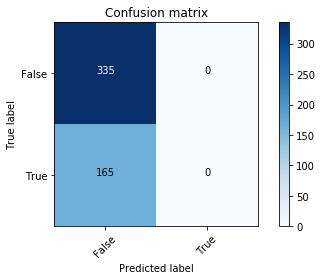

In [995]:
## Graphical visualization
cnf_matrix = confusion_matrix(test_labels, predicted_nn)
plt.figure()
class_names = ['False, True']
plot_confusion_matrix(cnf_matrix, classes=['False', 'True'],
                      Y_test = test_labels, predictions = predicted_nn,
                      title='Confusion matrix')

In [996]:
## Graph the data
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

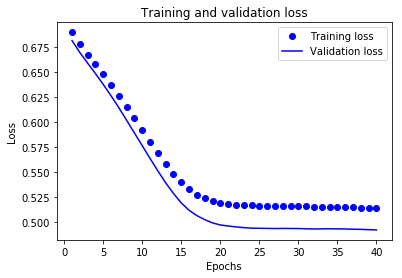

In [997]:
## Visualize training and validation loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

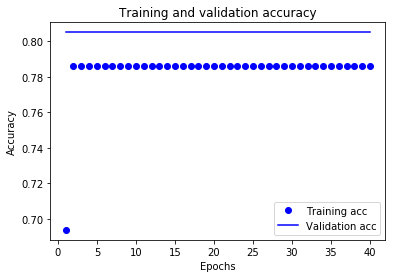

In [998]:
## Visualize training and validation accuracy
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Citation for parts of keras model
#@title MIT License
'#
'# Copyright (c) 2017 François Chollet
'#
'# Permission is hereby granted, free of charge, to any person obtaining a
'# copy of this software and associated documentation files (the "Software"),
'# to deal in the Software without restriction, including without limitation
'# the rights to use, copy, modify, merge, publish, distribute, sublicense,
'# and/or sell copies of the Software, and to permit persons to whom the
'# Software is furnished to do so, subject to the following conditions:
'#
'# The above copyright notice and this permission notice shall be included in
'# all copies or substantial portions of the Software.